In [1]:
import sys
sys.path.append('../')

In [2]:
import import_ipynb

In [3]:
from models.model_resnet18_FC             import Yolov1 as Yolo_resnet18
from models.model_resnet18_CNN_BLOCK_8_FC import Yolov1 as Yolo_resnet18_ft

from models.model_resnet50_FC             import Yolov1 as Yolo_resnet50
from models.model_resnet50_CNN_BLOCK_8_FC import Yolov1 as Yolo_resnet50_ft

from models.model_vgg19_FC                import Yolov1 as Yolo_VGG19
from models.model_vgg19_unfrozenCNN_FC    import Yolov1 as Yolo_VGG19_ft

importing Jupyter notebook from C:\Users\andri\Documents\Everything\YOLO-object-detection\train\..\models\model_resnet18_FC.ipynb
importing Jupyter notebook from C:\Users\andri\Documents\Everything\YOLO-object-detection\train\..\models\model_resnet18_CNN_BLOCK_8_FC.ipynb
importing Jupyter notebook from C:\Users\andri\Documents\Everything\YOLO-object-detection\train\..\models\model_resnet50_FC.ipynb
importing Jupyter notebook from C:\Users\andri\Documents\Everything\YOLO-object-detection\train\..\models\model_resnet50_CNN_BLOCK_8_FC.ipynb
importing Jupyter notebook from C:\Users\andri\Documents\Everything\YOLO-object-detection\train\..\models\model_vgg19_FC.ipynb
importing Jupyter notebook from C:\Users\andri\Documents\Everything\YOLO-object-detection\train\..\models\model_vgg19_unfrozenCNN_FC.ipynb


In [17]:
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
from dataset.dataset import VOCDataset
from train.utils import (
    non_max_suppression,
    mean_average_precision,
    intersection_over_union,
    cellboxes_to_boxes,
    get_bboxes,
    plot_image,
    save_checkpoint,
    load_checkpoint,
)
from loss.loss import YoloLoss
from tqdm import tqdm
from matplotlib import pyplot as plt

In [5]:
seed = 123
torch.manual_seed(seed)

# Hyperparameters etc. 
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 16 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0
EPOCHS = 300
# NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "overfit.pth.tar"
SAVE_MODEL_PATH = "../output/trained_models/best_model.pth"
IMG_DIR = "../dataset/data/preprocessed/training_images/"
LABEL_DIR = "../dataset/labels/"

In [6]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes

In [7]:
transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])

In [8]:
def train_fn(train_loader, model, optimizer, loss_fn):
    mean_loss = []

    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mean_loss = sum(mean_loss)/len(mean_loss)
    return mean_loss

In [9]:
model = Yolo_resnet18_ft(split_size=7, num_boxes=2, num_classes=1).to(DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
loss_fn = YoloLoss(S=7, B=2, C=1)

Unfrozen layer block 8:
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2)

In [10]:
if LOAD_MODEL:
    load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

In [11]:
train_dataset = VOCDataset(
    "../dataset/train_map.csv",# link of the train.csv file
    transform=transform,
    img_dir=IMG_DIR,
    label_dir=LABEL_DIR,
)

test_dataset = VOCDataset(
    "../dataset/val_map.csv", 
    transform=transform, 
    img_dir=IMG_DIR, 
    label_dir=LABEL_DIR,
)

In [12]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    # num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    # num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)

In [13]:
# early stopping variables
EARLY_STOPPING_LIMIT = 10
epochs_since_last_improvement = 0
best_loss = float('inf')
best_model = model.state_dict()

In [14]:
mean_loss_history = []
mean_avg_prec_history = []
for epoch in tqdm(range(EPOCHS)):
    # for x, y in train_loader:
    #    x = x.to(DEVICE)
    #    for idx in range(8):
    #        bboxes = cellboxes_to_boxes(model(x))
    #        bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
    #        plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

    #    import sys
    #    sys.exit()

    pred_boxes, target_boxes = get_bboxes(
        train_loader, model, iou_threshold=0.5, threshold=0.4
    )

    mean_avg_prec = mean_average_precision(
        pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
    )
    # print(f"Train mAP: {mean_avg_prec}")

    #if mean_avg_prec > 0.9:
    #    checkpoint = {
    #        "state_dict": model.state_dict(),
    #        "optimizer": optimizer.state_dict(),
    #    }
    #    save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
    #    import time
    #    time.sleep(10)

    mean_loss = train_fn(train_loader, model, optimizer, loss_fn)
    #print(f"Mean loss was {mean_loss}")
    
    # append metrics
    mean_avg_prec_history.append(mean_avg_prec)
    mean_loss_history.append(mean_loss)

    # early stopping
    if mean_loss < best_loss:
        epochs_since_last_improvement = 0
        best_loss = mean_loss
        best_model = model.state_dict() 
    else:
        epochs_since_last_improvement += 1
        if epochs_since_last_improvement >= EARLY_STOPPING_LIMIT:
            print(f"Early stopped at epoch {epoch}!")
            print(f"Best model at epoch {epoch-epochs_since_last_improvement}!")
            model.load_state_dict(best_model)
            break

 33%|██████████████████████████▋                                                      | 99/300 [10:49<21:59,  6.56s/it]

Early stopped at epoch 99!
Best model at epoch 89!


In [15]:
num_epochs = len(mean_avg_prec_history)

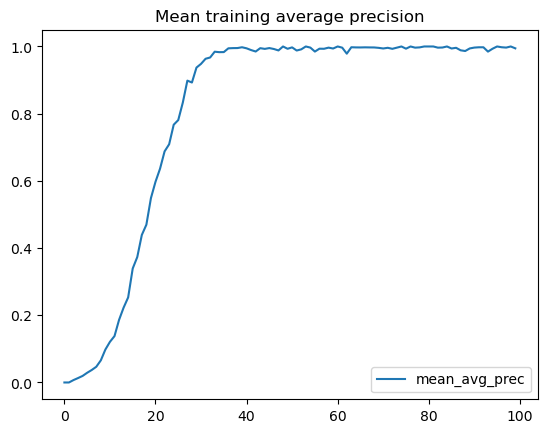

In [18]:
plt.plot(range(num_epochs), mean_avg_prec_history, label = 'mean_avg_prec')
plt.title("Mean training average precision")
plt.legend()
plt.show()

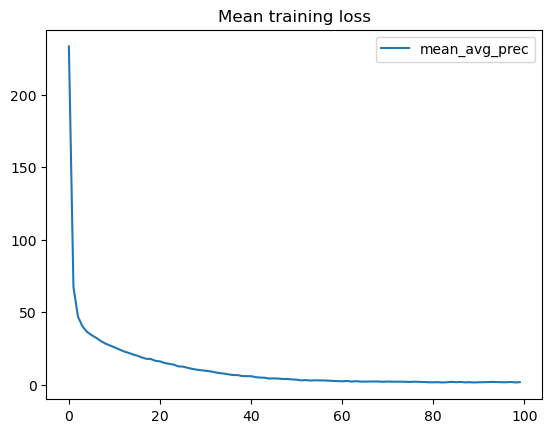

In [19]:
plt.plot(range(num_epochs), mean_loss_history, label = 'mean_avg_prec')
plt.title("Mean training loss")
plt.legend()
plt.show()

In [20]:
# saving a model
torch.save(model.state_dict(), SAVE_MODEL_PATH)